In [2]:
import warnings

import dill

# Data Manipulation
import pandas as pd
import numpy as np

# Imputation - RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Transformation
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Pipeline
from sklearn.pipeline import Pipeline

# Metrics
import math
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score

# Regression Algorithms
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from catboost import CatBoostRegressor

%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore')  # Disabling warning outputs

In [3]:
# Path to the CSV data file 
# Reading data from the CSV file into a DataFrame using the first column as the index
df = pd.read_csv(r'..\datasets\dynamic_pricing.csv')  


# Displaying the first few rows of the DataFrame
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [4]:
# Initialize empty lists to store object and non-object columns
obj = []
ints = []

# Loop through DataFrame columns
for col in df.columns:
    # Check if column data type is object
    if df[col].dtype == 'object':
        # If object, append column name, unique values count, and count of missing values to 'obj' list
        obj.append((col, df[col].nunique(), df[col].isna().sum()))
    else:
        # If non-object, append column name, unique values count, and count of missing values to 'ints' list
        ints.append((col, df[col].nunique(), df[col].isna().sum(), df[col].skew()))

# Determine the maximum length of 'obj' and 'ints' lists
max_len = max(len(obj), len(ints))

# Extend 'obj' and 'ints' lists with empty tuples to match the maximum length
obj.extend([('', '', '')] * (max_len - len(obj)))
ints.extend([('', '', '', '')] * (max_len - len(ints)))

# Create a dictionary with keys representing column categories and values representing lists of corresponding data
data = {
    'Categorical_columns': [x[0] for x in obj],
    'cat_cols_uniques': [x[1] for x in obj],
    'cat_cols_missing': [x[2] for x in obj],
    'Numeric_columns': [x[0] for x in ints],
    'int_cols_uniques': [x[1] for x in ints],
    'int_cols_missing': [x[2] for x in ints],
    'int_cols_skew': [x[3] for x in ints]
}

# Convert the dictionary into a pandas DataFrame
pd.DataFrame(data)

,Categorical_columns,cat_cols_uniques,cat_cols_missing,Numeric_columns,int_cols_uniques,int_cols_missing,int_cols_skew
0,Location_Category,3,0,Number_of_Riders,81,0,0.002167
1,Customer_Loyalty_Status,3,0,Number_of_Drivers,79,0,0.963204
2,Time_of_Booking,4,0,Number_of_Past_Rides,101,0,-0.008457
3,Vehicle_Type,2,0,Average_Ratings,151,0,-0.078754
4,,,,Expected_Ride_Duration,171,0,-0.139868
5,,,,Historical_Cost_of_Ride,1000,0,0.209580


In [5]:
# This line of code retrieves the shape of the DataFrame 'df'
shape = df.shape
print(shape)

(1000, 10)


In [6]:
# Displaying concise summary information about the DataFrame, including
# data types, non-null values, and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


In [7]:
# Displaying the data types of each column in the DataFrame
df.dtypes

Number_of_Riders             int64
Number_of_Drivers            int64
Location_Category           object
Customer_Loyalty_Status     object
Number_of_Past_Rides         int64
Average_Ratings            float64
Time_of_Booking             object
Vehicle_Type                object
Expected_Ride_Duration       int64
Historical_Cost_of_Ride    float64
dtype: object

In [8]:
# Counting the number of duplicated rows in the DataFrame and then counting
# the frequency of those counts to summarize the distribution of duplicated rows
df.duplicated().value_counts()

False    1000
Name: count, dtype: int64

In [9]:
df.columns

Index(['Number_of_Riders', 'Number_of_Drivers', 'Location_Category',
       'Customer_Loyalty_Status', 'Number_of_Past_Rides', 'Average_Ratings',
       'Time_of_Booking', 'Vehicle_Type', 'Expected_Ride_Duration',
       'Historical_Cost_of_Ride'],
      dtype='object')

In [10]:
# Exploratory Data Analysis
# Generate descriptive statistics for all numerical columns
df.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


In [11]:
# Generate descriptive statistics for categorical columns
df.describe(include='object')

,Location_Category,Customer_Loyalty_Status,Time_of_Booking,Vehicle_Type
count,1000,1000,1000,1000
unique,3,3,4,2
top,Urban,Silver,Night,Premium
freq,346,367,276,522


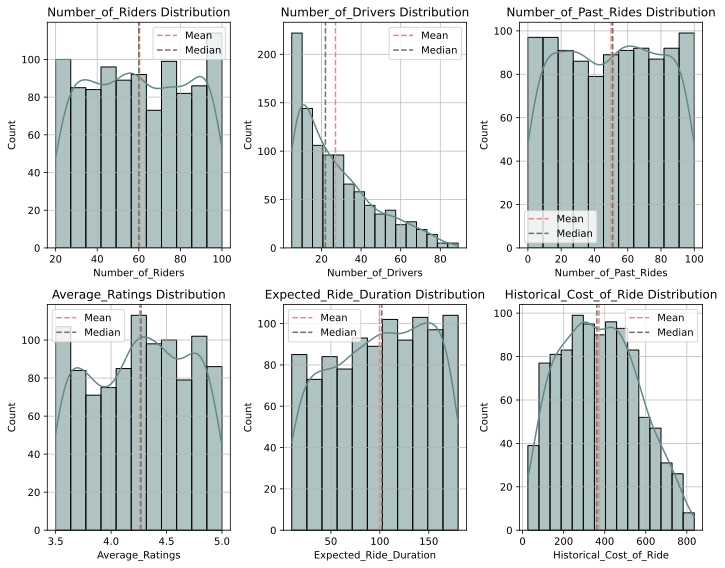

In [12]:
# Visualising Categorical and Numerical features distributions

# Select numerical columns from the DataFrame
numerics = df.select_dtypes(include='number')

# Calculate the number of plots, rows, and columns for subplots
num_plots = len(numerics.columns)
num_columns = 3
num_rows = num_plots // num_columns + (1 if num_plots % num_columns > 0 else 0)



# Set the figure size based on the number of rows
plt.figure(figsize=(10, 4 * num_rows))

# Iterate over each numerical column and create a histogram subplot
for i, col in enumerate(numerics, 1):
    plt.subplot(num_rows, num_columns, i)  # Create subplot
    mean_values = numerics[col].mean()
    median = numerics[col].median()

    sns.histplot(numerics[col], kde=True, color='#638889')  # Plot histogram using seaborn
    plt.axvline(x=mean_values, color='#F28585', linestyle='--', label='Mean')
    plt.axvline(x=median, color='#747264', linestyle='--', label='Median')
    plt.grid(True, alpha=0.8)  # Add grid lines to the plot
    plt.title(f'{col} Distribution')  # Set title for the subplot
    plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plots

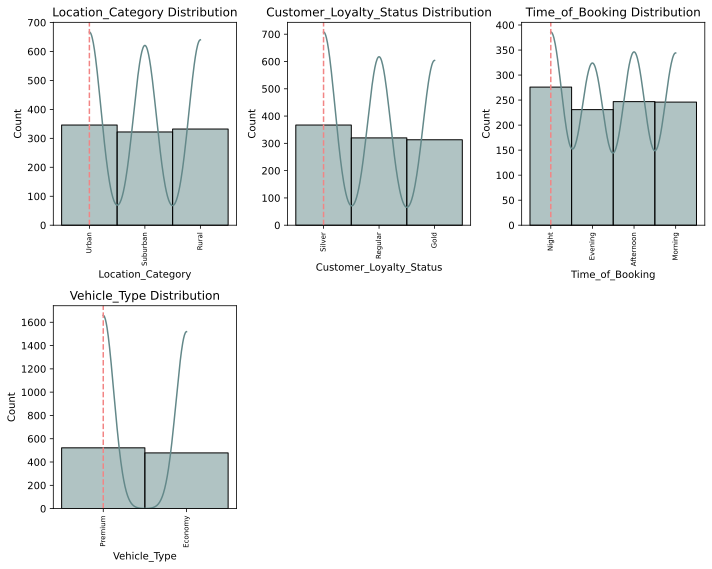

In [13]:
# Select categorical columns from the DataFrame
categorical_cols = df.select_dtypes(include=['object']).columns

# Calculate the number of plots, rows, and columns for subplots
num_plots = len(categorical_cols)
num_columns = 3
num_rows = num_plots // num_columns + (1 if num_plots % num_columns > 0 else 0)

# Set the figure size based on the number of rows
plt.figure(figsize=(10, 4 * num_rows))

# Iterate over each categorical column and create a histogram subplot
for i, col in enumerate(df[categorical_cols], 1):
    mode = df[col].mode()[0]    
    plt.subplot(num_rows, num_columns, i)  # Create subplot
    sns.histplot(df[col], kde=True, color='#638889')  # Plot histogram using seaborn

    plt.axvline(x=mode, color='#F28585', linestyle='--', label='Mode')

    plt.xticks(rotation=90, fontsize=7)  # Rotate x-axis labels for better readability
    plt.title(f'{col} Distribution')  # Set title for the subplot

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plots

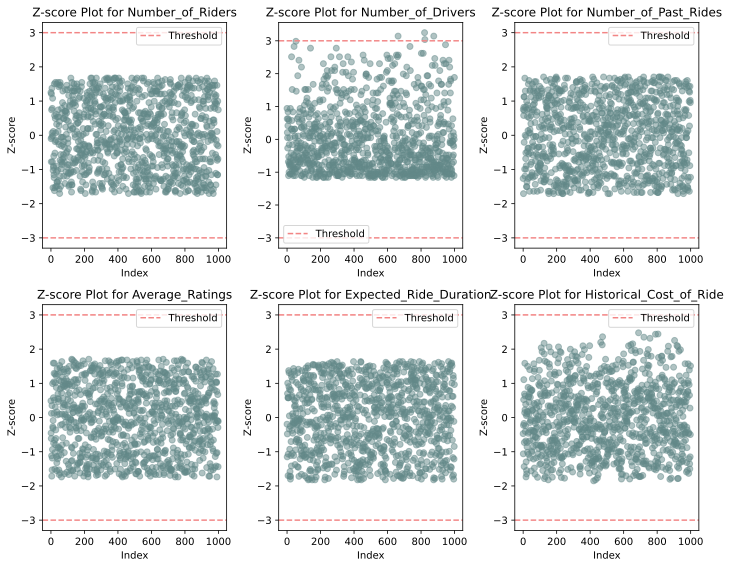

In [14]:
numerics = df.select_dtypes(include=np.number)

# Calculate the number of plots, rows, and columns for subplots
num_plots = len(numerics.columns)
num_columns = 3
num_rows = num_plots // num_columns + (1 if num_plots % num_columns > 0 else 0)

# Set the figure size based on the number of rows
plt.figure(figsize=(10, 4 * num_rows))

for i, col in enumerate(numerics, 1):
    plt.subplot(num_rows, num_columns, i)  
    z_scores = (numerics[col] - numerics[col].mean()) / numerics[col].std()

    threshold = 3

    plt.scatter(np.arange(len(z_scores)), z_scores, color='#638889', alpha=0.5)
    plt.axhline(y=threshold, color='#F28585', linestyle='--', label='Threshold')
    plt.axhline(y=-threshold, color='#F28585', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Z-score')
    plt.title(f'Z-score Plot for {col}')
    plt.legend()

plt.tight_layout()
plt.show()

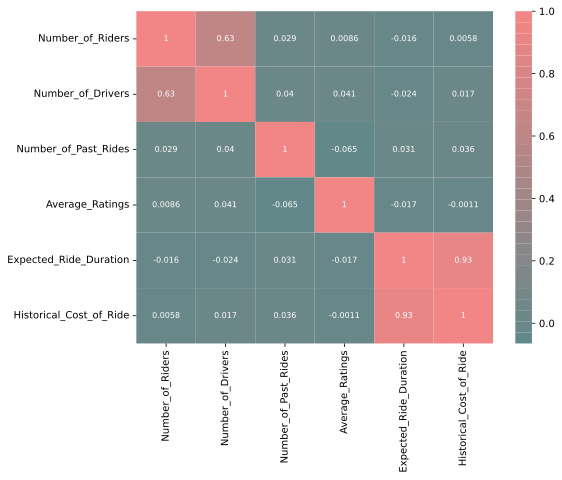

In [15]:
# Visualising correlation

# Set the figure size
plt.figure(figsize=(8, 6))

# Create a heatmap of the correlation matrix for numerical columns in the dataframe
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, 
            cmap=['#638889', '#678788', '#6c8788', '#718788', '#768788',
                  '#7b8788', '#808788', '#858788', '#8a8787', '#8f8787',
                  '#948687', '#998687', '#9e8687', '#a38687', '#a88687',
                  '#ac8686', '#b18686', '#b68686', '#bb8686', '#c08686',
                  '#c58586', '#ca8586', '#cf8585', '#d48585', '#d98585',
                  '#de8585', '#e38585', '#e88585', '#ed8585', '#f28585'], annot_kws={"fontsize":8})

# Show the plot
plt.show()

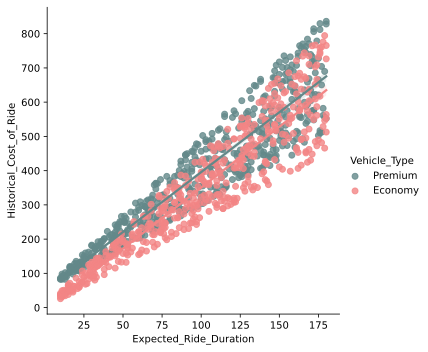

In [16]:
# Create a scatter plot with linear regression lines using seaborn's lmplot
sns.lmplot(data=df, y='Historical_Cost_of_Ride', x='Expected_Ride_Duration', hue='Vehicle_Type', 
           palette=['#638889', '#f28585'])

# Show the plot
plt.show()

In [17]:
# Dynamic price calc

# Calculate demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

df['demand_multiplier'] = np.where(df['Number_of_Riders'] > np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                   df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                   df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], low_demand_percentile))

# Calculate supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

df['supply_multiplier'] = np.where(df['Number_of_Drivers'] > np.percentile(df['Number_of_Drivers'], 
                                                                           low_supply_percentile),
                                   np.percentile(df['Number_of_Drivers'], high_supply_percentile)
                                   / df['Number_of_Drivers'], np.percentile(df['Number_of_Drivers'], 
                                                                            low_supply_percentile) 
                                   / df['Number_of_Drivers'])

# Define price adjustment factors for high and low demand/supply
demand_threshold_high = 1.2  # Higher demand threshold
demand_threshold_low = 0.8  # Lower demand threshold
supply_threshold_high = 0.8  # Higher supply threshold
supply_threshold_low = 1.2  # Lower supply threshold

# Calculate adjusted_ride_cost for dynamic pricing
df['adjusted_ride_cost'] = df['Historical_Cost_of_Ride'] * (
    np.maximum(df['demand_multiplier'], demand_threshold_low) *
    np.maximum(df['supply_multiplier'], supply_threshold_high)
)

In [18]:
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,demand_multiplier,supply_multiplier,adjusted_ride_cost
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,1.111111,0.844444,266.710528
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,1.450000,0.974359,245.653817
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,1.050000,1.225806,424.478684
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,1.098765,1.357143,701.155452
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,1.950000,1.727273,1952.472427


In [19]:
# Profability Analysis of rides

# Calculate the profit percentage for each ride
df['profit_percentage'] = ((df['adjusted_ride_cost'] - df['Historical_Cost_of_Ride']) 
                           / df['Historical_Cost_of_Ride']) * 100
# Identify profitable rides where profit percentage is positive
profitable_rides = df[df['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = df[df['profit_percentage'] < 0]

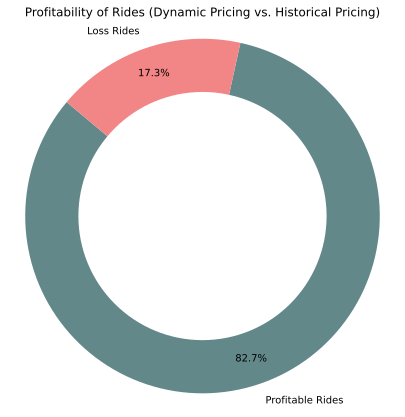

In [20]:
# Calculate the profit percentage for each ride
df['profit_percentage'] = ((df['adjusted_ride_cost'] - df['Historical_Cost_of_Ride']) 
                           / df['Historical_Cost_of_Ride']) * 100
# Identify profitable rides where profit percentage is positive
profitable_rides = df[df['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = df[df['profit_percentage'] < 0]

# Calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a donut chart to show the distribution of profitable and loss rides
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

plt.figure(figsize=(7, 7))

# Create a pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, 
        colors = ['#638889', '#f28585'], labeldistance = 1.1,
                  pctdistance = 0.85, normalize=True
)

# Draw a circle in the center to create a ring
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')


plt.show()

In [21]:
# Calculate the skewness of the target variable 'TARGET' and round the result to 2 decimal places
print("Skewness: ", round(df['adjusted_ride_cost'].skew(), 2))

Skewness:  1.58


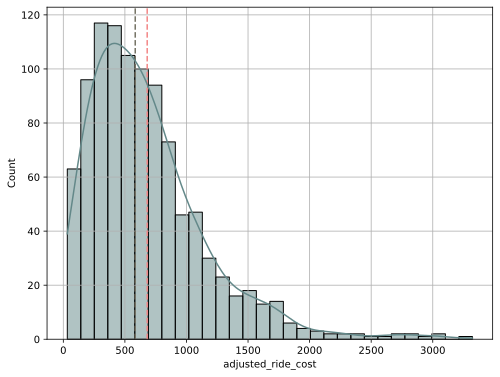

In [22]:
# Create a new figure with a specified size (8 inches width, 6 inches height)
plt.figure(figsize=(8, 6))


# Calculate the mean and median of the 'adjusted_ride_cost' column
mean_values = df['adjusted_ride_cost'].mean()
median = df['adjusted_ride_cost'].median()

# Add vertical lines for mean and median to the plot
plt.axvline(x=mean_values, color='#F28585', linestyle='--', label='Mean')
plt.axvline(x=median, color='#747264', linestyle='--', label='Median')

# Create a histogram plot with KDE (Kernel Density Estimation)
sns.histplot(df['adjusted_ride_cost'], kde=True, color='#638889')

# Add grid lines to the plot
plt.grid(True)

# Display the plot
plt.show()

In [23]:
# Apply the natural logarithm transformation plus 1 to the target variable 'TARGET'
df['adjusted_ride_cost'] = np.log1p(df['adjusted_ride_cost'])

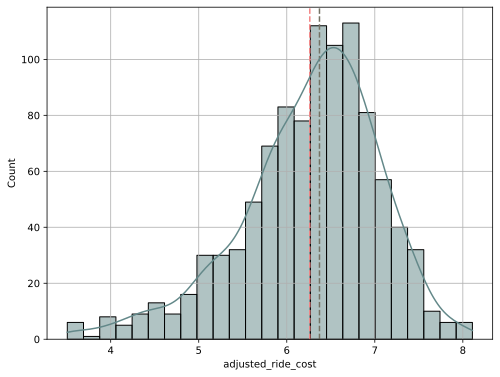

In [24]:
# Create a new figure with a specified size (8 inches width, 6 inches height)
plt.figure(figsize=(8, 6))

# Calculate the mean and median of the 'adjusted_ride_cost' column
mean_value = df['adjusted_ride_cost'].mean()
median = df['adjusted_ride_cost'].median()

# Plot vertical lines indicating mean and median on the histogram plot
plt.axvline(x=mean_value, color='#F28585', linestyle='--', label='Mean')
plt.axvline(x=median, color='#747264', linestyle='--', label='Median')

# Create a histogram plot with KDE (Kernel Density Estimation)
sns.histplot(df['adjusted_ride_cost'], kde=True, color='#638889')

# Add grid lines to the plot
plt.grid(True)

# Display the plot
plt.show()

In [25]:
# Calculate the skewness of the transformed target variable 'TARGET' and round the result to 2 decimal places
print("Skewness: ", round(df['adjusted_ride_cost'].skew(), 2))

Skewness:  -0.72


In [26]:
# Print the skewness of the transformed 'Number_of_Drivers' column
print("Skewness: ", round(df['Number_of_Drivers'].skew(), 2))

Skewness:  0.96


In [27]:
# Estimate the optimal Box-Cox transformation parameter lambda for 'Number_of_Drivers' column
lambda_est = boxcox_normmax(df['Number_of_Drivers'] + 2, brack=(-1.5, 1.5))

# Apply the Box-Cox transformation to the 'Number_of_Drivers' column using the estimated lambda
df['Number_of_Drivers'] = boxcox1p(df['Number_of_Drivers'], lambda_est)

# Print the skewness of the transformed 'Number_of_Drivers' column
print("Skewness: ", round(df['Number_of_Drivers'].skew(), 2))

Skewness:  -0.01


In [28]:
# Data splitting

# Create the TRAIN subset by selecting rows where the target variable TARGET is not null
TARGET = df['adjusted_ride_cost']

# Create the TEST subset by selecting rows where the target variable TARGET is null
df = df.drop(columns=['adjusted_ride_cost'])

In [29]:
# Count the number of columns for each data type and display the counts
df.dtypes.value_counts()

float64    6
object     4
int64      3
Name: count, dtype: int64

In [30]:
df['Vehicle_Type'] = df['Vehicle_Type'].map({'Economy': 0, 'Premium': 1})

# Assign the feature matrix X to the TRAIN DataFrame
X = df[['Number_of_Riders', 'Number_of_Drivers', 'Expected_Ride_Duration', 'Vehicle_Type']]


# Подгоняем полином к набору данных
coefficients = np.polyfit(X['Number_of_Riders'].values, X['Number_of_Drivers'].values, deg=2)

poly = np.poly1d(coefficients)

division_feature = poly(X['Number_of_Riders'].values / X['Number_of_Drivers'].values)


# Преобразуем результат обратно в Series
X['interpolated_division'] = pd.Series(division_feature)

In [31]:
# Standardizing Features with StandardScaler

In [33]:
import os
import dill
from sklearn.preprocessing import StandardScaler

# Assign y and scale X
y = TARGET
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Absolute path to your file
save_path = r"C:\Users\admin\OneDrive\Desktop\MLDL project\SmartMarketer\ml-backend\data-ops\scaler.pkl"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the scaler
with open(save_path, "wb") as file:
    dill.dump(scaler, file)

print(f"Scaler saved to: {save_path}")


Scaler saved to: C:\Users\admin\OneDrive\Desktop\MLDL project\SmartMarketer\ml-backend\data-ops\scaler.pkl


In [35]:
# Split the scaled features and the target variable y into training and testing sets
# The test set will be 30% of the total data, and the random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [38]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Building Pipeline
# Dictionary containing regression models
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
    'CatBoostRegressor': CatBoostRegressor(verbose=0)
}

# Dictionary containing hyperparameter grids for each model
params = {
    'Ridge': {'model__alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'model__alpha': [0.001, 0.01, 0.1]},
    'ElasticNet': {'model__alpha': [0.001, 0.01, 0.1], 'model__l1_ratio': [0.2, 0.5, 0.8]},
    'SVR': {'model__C': [0.1, 1, 10], 'model__epsilon': [0.1, 0.2, 0.5], 'model__kernel': ['linear', 'rbf']},
    'RandomForestRegressor': {'model__n_estimators': [10, 50, 100]},
    'XGBRegressor': {'model__learning_rate': [0.1, 0.5], 'model__max_depth': [3, 5, 7]},
    'CatBoostRegressor': {'model__learning_rate': [0.01, 0.1, 0.5], 'model__depth': [4, 6, 8]}
}

In [39]:
# # Define a function to calculate the root mean squared error (RMSE)
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

# # Create a custom scorer 'rmse_scorer' using make_scorer
# # 'greater_is_better=False' indicates that lower values of the scoring function are better
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [ ]:
# # Initialize an empty list to store the results
results = []

# # Initialize variables to track the best model and its R-squared score
best_model = None
best_r2 = float('-inf')

# # Iterate over each model in the models dictionary
for name, model in models.items():
    # Create a pipeline with the model
    pipeline = Pipeline([
        ('model', model)
    ])
    
#     # Check if hyperparameters for the current model are defined in the params dictionary
    if name in params:
#         # If hyperparameters are defined, perform grid search with cross-validation
        grid_search = GridSearchCV(pipeline, params[name], cv=5, scoring=rmse_scorer)
    else:
#         # If hyperparameters are not defined, perform grid search with default hyperparameters
        grid_search = GridSearchCV(pipeline, {}, cv=5, scoring=rmse_scorer)
      
#     # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)
    
#     # Make predictions on the test set
    y_pred = grid_search.predict(X_test)
    
#     # Calculate R-squared score and RMSE on the test set
    r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))
    rmse_val = rmse(np.expm1(y_test), np.expm1(y_pred))


#     # Update the best model and its R-squared score if the current model performs better
    if r2 > best_r2:
        best_r2 = r2
        best_model = grid_search
    
#     # Append the results to the results list
    results.append({
        'Model': name,
        'R-Squared Score': r2,
        'RMSE Score': rmse_val,
        'Best Parameters': grid_search.best_params_
    })

# # Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [ ]:
# # Set the display option to show all the contents of DataFrame columns without truncation
pd.set_option('display.max_colwidth', None)

# # Set the display option to format float numbers with a precision of 5 decimal places
pd.set_option('display.float_format', '{:.5f}'.format)

# # Display the DataFrame results_df
print(results_df)

In [ ]:
# # Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# # Calculate the R-squared (R2) score using the predictions and true target values
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))

# # Print the R-squared (R2) score
print(f"R-squared (R2): {r2}")

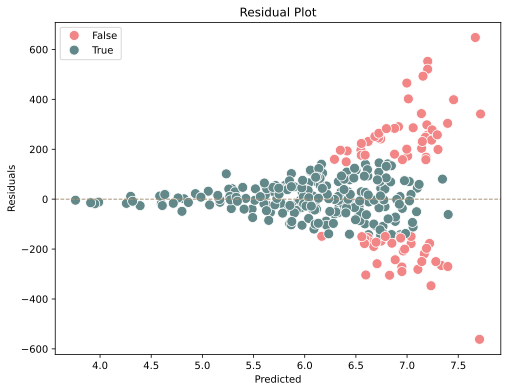

In [45]:
# # Calculate residuals
residuals = np.expm1(y_test) - np.expm1(y_pred)

# # Calculate standard deviation of residuals
sigma = np.std(residuals)

# # Create a list for hue parameter
hue = list(map(lambda x: abs(x) < sigma, residuals))

# # Create a residual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, hue=hue, palette = ['#f28585', '#638889'], s=100)
plt.axhline(y=0, color='#A79277', linestyle='--', lw=1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [52]:
# Create a CatBoostRegressor model with specified hyperparameters
model = CatBoostRegressor(verbose=0, subsample=0.9, learning_rate=0.05000000000000001, l2_leaf_reg=2,
                          iterations=350, depth=4)

# Fit the model to the training data
model.fit(X_train, y_train)

# Extract feature importances from the trained model
feature_coefficients = pd.DataFrame(model.feature_importances_, index=X.columns,
                                    columns=['Importance']).sort_values(by='Importance', ascending=False)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R-squared (R2) score using the predictions and true target values
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))

# Print the R-squared (R2) score
print(f"R-squared (R2): {r2}")

R-squared (R2): 0.8969610131255433


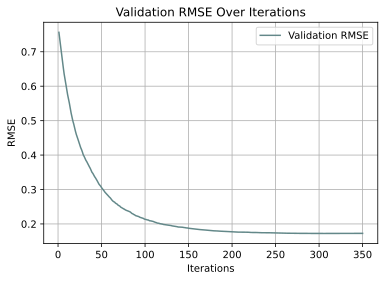

In [53]:
# Fit the model to the training data and evaluate it on the test set
# use_best_model=True ensures that the model uses the best iteration based on early stopping
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Get the RMSE values during training from the evaluation set
train_log_loss = model.get_evals_result()['validation']['RMSE']

# Plot RMSE over iterations
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(train_log_loss) + 1), train_log_loss, label='Validation RMSE', color='#638889')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Validation RMSE Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

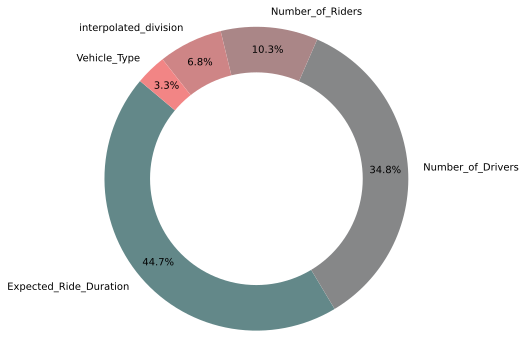

In [54]:
plt.figure(figsize=(6, 6))

# Create a pie chart
plt.pie(feature_coefficients['Importance'].values, labels=feature_coefficients.index, autopct='%1.1f%%', startangle=140, 
        colors = ['#638889', '#868788', '#aa8687', '#ce8586', '#f28585'], labeldistance = 1.1,
                  pctdistance = 0.85, normalize=True
)

# Draw a circle in the center to create a ring
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.show()